<h1><center> IBM Data Science Capstone<center\><h1\>

<img src="image/Wellington_Map.png" /> <img src="image/Wellington_NZ.jpg" />


# <center> Opening a French Restaurant in Wellington, New Zealand
# Introduction
##  Description of the problem:
Wellington is New Zealand's capital making it the world's southernmost capital of a sovereign state. It is the third-largest by population in New Zealand. Wellington City consists of the central historic town and certain additional areas within the Wellington metropolitan area, extending as far north as Linden and covering rural areas such as Mākara and Ohariu. It has an urban population of 215,400 over an urban area of 442 km^2.

Wellington is characterised by small dining establishments, and its café culture is internationally recognised, being known for its large number of coffeehouses. Restaurants offer cuisines including from Europe, Asia and Polynesia; for dishes that have a distinctly New Zealand style, there are lamb, pork and cervena (venison), salmon, crayfish (lobster), Bluff oysters, pāua (abalone), mussels, scallops, pipis and tuatua (both New Zealand shellfish); kumara (sweet potato); kiwifruit and tamarillo; and pavlova, the national dessert. (source: Wikipedia)

There is definitely a community of foodies in Wellington and a demand for European cuisine. French cuisine being the most famous and appreciated European cuisine, it is also highly regarded internationaly for its supposed refinement and fanciness. French restaurant in non-French speaking countries are thus generally quite fancy and pricy.

Hence, to open a restaurant, one has to look at:
* Areas where people have a sufficient standard of living to frequent the restaurant regularly,
* Areas not overcrowded with restaurants, but still lively, having enough venues around,
* Areas where the housing price is not too expensive since one want to reduce the initial cost of the acquisition of the restaurant building thus reducing the risk of the investment.

## Description of the data:
The data that have been successfully collected and their use are listed below:
* **Wellington's Wards and Suburbs Dataset** scraped from the Wikipedia Page of Wellington (https://en.wikipedia.org/wiki/Wellington#Economy, table: *Official suburbs of Wellington City, New Zealand*). The coordinates of the Wellington City suburbs are then collected thanks to the Python library GeoPy.


* **Median house price per Suburb of the Wellington Region as of September 2019 Dataset** compiled manually into a csv file from the website https://blog.homes.co.nz/wellington-median-house-price-by-suburb/#https://blog.homes.co.nz/wellington-median-house-price-by-suburb/. This dataset will be use to find a suburb where the acquisition cost of a restaurant is appropriate.


* **Victimisations Numbers for Wellington City per Area Unit (7/1/2014 to 3/1/2020) Dataset** found on the New Zealand police website (https://www.police.govt.nz/about-us/publications-statistics/data-and-statistics/policedatanz
/victimisation-time-and-place). This dataset permits to assess the insecurity level of each Area Unit as we do not want workers or customers of the restaurants to feel uneasy to go to the restaurant as night/dinner time is a prime time for restaurants as well as victimisations. Moreover, we want to avoid putting the restaurants into an area where it will be likely to get stolen or vandalised.


* **Census - Median household income per Area Unit 2001, 2006, 2013 Dataset** for all Area Unit of New Zealand. The data is provided by Stats NZ and can be found on the following website: https://figure.nz/table/SSkBckhaaTU3hRqA. This dataset is used to explore the areas where the households have a sufficient income and lifestyle to frequent a French restaurant regularly.


* **Area Unit 2013** provided by Stats NZ and available at https://datafinder.stats.govt.nz/layer/25743-area-unit-2013/. This is the definitive set of area unit boundaries for 2013 as defined by Statistics New Zealand as at 1 January 2013. The data defines the boundaries of all Area Unit of New Zealand. First, The Wellington City's Area Unit boundaries are extracted. Then, the data is converted to GeoJSON and used to create choropleth map.


* **Wellington Venues**, obtained using the **Foursquare API**. Foursquare API is used to get the common venues of the different areas, including the restaurants and their numbers.


* **Wellington French Restaurants**, obtained using the **Foursquare API**. Foursquare API is used to get the French Restaurants of the different areas.

###### Suburb vs Area unit


The datasets collected are either grouped by Area Unit or by Suburb. Wellington have 57 suburbs and is divided into 78 Area Unit. Some Suburbs contain several Area Units and some Area Units contain several Suburbs.


Suburb are official denomination representing the different parts of Wellington City, each having their own center.

Area units are aggregations of adjacent meshblocks with coterminous boundaries to form a single unbroken surface area (land and/or water). Exceptions to this rule are some area units comprising collections of geographically related inlets and marinas. In an urban location, an area unit is often a collection of city blocks, while in rural situations area units may be equated to localities or communities. Area units must either define or aggregate to define urban areas, rural centres, statistical areas, territorial authorities, and regional councils.
Each area unit must be a single geographic entity with a unique name. The area unit pattern is revised once every five years in the year immediately before a Census of Population and Dwellings. There may also be changes in other years, in conjunction with local body boundary changes.


The question is, do we want to open a French restaurant in the best Area unit or in the best Suburb? This is a question that is worth asking. Indeed, looking solely at the numbers, it seems that Area Unit correspond to a thinner decomposition of the city that could show patterns inside suburbs. However, this might lead to overfit our analysis and results. Suburbs might also make more sense since it does not depend on the specific geography of the area. 

Bearing these consideration in mind, we choose to select the Suburb slicing of Wellington as it seems more appropriate for our problem.

In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
from scipy import stats

#!pip install geopandas
import geopandas

#!conda install -c conda-forge geopy --yes # uncomment this line if geocoder is not installed
from geopy.geocoders import Nominatim# import geocoder

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if folium is not installed
import folium

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler, RobustScaler

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from tqdm import tqdm # to time for loop

# Data Gathering and Cleaning

## Wellington's Wards and Suburbs Dataset : Scrapping Wikipedia

Getting the table via the URL

In [2]:
res = requests.get("https://en.wikipedia.org/wiki/Template:Suburbs_of_Wellington_City")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))[0]
df

,"vteOfficial suburbs of Wellington City, New Zealand","vteOfficial suburbs of Wellington City, New Zealand.1"
0,Northern Ward,Churton Park Glenside Grenada Grenada North Ho...
1,Onslow-Western Ward,Broadmeadows Crofton Downs Kaiwharawhara Karor...
2,Lambton Ward,Aro Valley Kelburn Wellington Central Mount Vi...
3,Southern Ward,Brooklyn Berhampore Island Bay Newtown Vogelto...
4,Eastern Ward,Hataitai Lyall Bay Kilbirnie Miramar Seatoun B...


Rearranging the table

In [3]:
df.columns=['Ward','Suburb']

In [4]:
wellington_sub = {'Ward':[],'Suburb':[]}

prefix = ['Mount', 'Te']
suffix = ['Park', 'Valley', 'Bay', 'Bays', 'North', 'Downs', 'Beach', 'Central', 'Point']

for i in df.index:
    l = df.loc[i,'Suburb'].split(' ')
    prefix_io = False
    prefix_found = ''
    for sub in l:
        if sub in suffix:
            wellington_sub['Suburb'][-1] = (wellington_sub['Suburb'][-1] + ' ' + sub).capitalize()
        elif sub in prefix:
            prefix_io = True
            prefix_found = sub
        elif prefix_io:
            wellington_sub['Ward'].append(df.loc[i,'Ward'])
            wellington_sub['Suburb'].append((prefix_found + ' ' + sub).capitalize())
            prefix_io = False
        else:
            wellington_sub['Ward'].append(df.loc[i,'Ward'])
            wellington_sub['Suburb'].append(sub.capitalize())

In [5]:
wellington_sub = pd.DataFrame(wellington_sub)
print('The dataframe has a shape of:', wellington_sub.shape)
print('Wellington has {} Suburbs, divided into {} Wards.'.format(wellington_sub['Suburb'].unique().size,\
                                                                 wellington_sub['Ward'].unique().size))
wellington_sub.head()

The dataframe has a shape of: (57, 2)
Wellington has 57 Suburbs, divided into 5 Wards.


,Ward,Suburb
0,Northern Ward,Churton park
1,Northern Ward,Glenside
2,Northern Ward,Grenada
3,Northern Ward,Grenada north
4,Northern Ward,Horokiwi


## Median house price per suburb of the Wellington Region as of September 2019 Dataset

Reading the csv file

In [6]:
house_df = pd.read_csv('data/Housing_price.csv')
house_df.head()

,SUBURB,MEDIAN HOUSE PRICE (NZD)
0,ORIENTAL BAY (Wellington),1807920
1,SEATOUN (Wellington),1325884
2,KELBURN (Wellington),1237852
3,KARAKA BAYS (Wellington),1225803
4,KAIWHARAWHARA (Wellington),1213231


#### Extracting the data about Wellington City

We process the data of the first column into two columns to build the new column 'City'

In [7]:
house_df['MEDIAN HOUSE PRICE (NZD)'] = house_df['MEDIAN HOUSE PRICE (NZD)'].astype('int')

city_dict = {'City':[]}
for i in house_df.index:
    city_dict['City'].append(house_df.loc[i,'SUBURB'].split(' (')[1][:-1])
    house_df.loc[i,'SUBURB'] = house_df.loc[i,'SUBURB'].split(' (')[0].capitalize()
house_df['City'] = pd.DataFrame(city_dict)
house_df.head()

,SUBURB,MEDIAN HOUSE PRICE (NZD),City
0,Oriental bay,1807920,Wellington
1,Seatoun,1325884,Wellington
2,Kelburn,1237852,Wellington
3,Karaka bays,1225803,Wellington
4,Kaiwharawhara,1213231,Wellington


We extract the data corresponding to Wellington City

In [8]:
house_wel_df = house_df[house_df['City']=='Wellington'][['SUBURB','MEDIAN HOUSE PRICE (NZD)']]
house_wel_df.rename(columns = {'SUBURB': 'Suburb'} , inplace = True)
house_wel_df.head()

,Suburb,MEDIAN HOUSE PRICE (NZD)
0,Oriental bay,1807920
1,Seatoun,1325884
2,Kelburn,1237852
3,Karaka bays,1225803
4,Kaiwharawhara,1213231


## Merging the two dataset into one

We do an outer join to make sure no data is forgotten and to account for possible formatting issue

In [9]:
wellington_df = wellington_sub.join(house_wel_df.set_index('Suburb'), on = 'Suburb', how = 'outer').reset_index(drop=True)
wellington_df.head()

,Ward,Suburb,MEDIAN HOUSE PRICE (NZD)
0,Northern Ward,Churton park,835393.0
1,Northern Ward,Glenside,513324.0
2,Northern Ward,Grenada,NaN
3,Northern Ward,Grenada north,502478.0
4,Northern Ward,Horokiwi,NaN


We can see that two formatting exist for several suburbs and we choose the formats without special characters

In [10]:
# SYNTAX ISSUE
wellington_df.loc[57, 'Ward'] = wellington_df.loc[2,'Ward']
wellington_df.loc[59, 'Ward'] = wellington_df.loc[16,'Ward']
wellington_df.loc[58, 'Ward'] = wellington_df.loc[42,'Ward']

wellington_df.drop(index = [2,16, 42], axis = 0, inplace = True)                

Let's see which neighborhood did not has their median house price listed

In [11]:
wellington_df[wellington_df['MEDIAN HOUSE PRICE (NZD)'].isna()]

,Ward,Suburb,MEDIAN HOUSE PRICE (NZD)
4,Northern Ward,Horokiwi,NaN
9,Northern Ward,Takapu valley,NaN
17,Onslow-Western Ward,Mākara beach,NaN
19,Onslow-Western Ward,Ngauranga,NaN
21,Onslow-Western Ward,Ohariu,NaN
53,Eastern Ward,Moa point,NaN


Let's solve this issue making several hypothesis:
* Hypothesis 1: Makara and Makara Beach share the same mean housing price
* Hypothesis 2: Grenada North and Tapaku Valley have the same mean housing price because they are very close to each other
* Hypothesis 3: For the other suburb, the Suburb correspond to almost inhabited region or park, we will take as price the average price

In [12]:
## Hypothesis 1: Makana and Makana Beach same mean housing price
wellington_df.loc[17,['Suburb', 'MEDIAN HOUSE PRICE (NZD)']] = ['Makara beach', wellington_df.loc[58, 'MEDIAN HOUSE PRICE (NZD)']]

## Hypothesis 2: Grenada North and Tapaku Valley same mean housing price because very close to each other
wellington_df.loc[9, 'MEDIAN HOUSE PRICE (NZD)'] = wellington_df.loc[3, 'MEDIAN HOUSE PRICE (NZD)']

## Hypothesis 3: For the other suburb, the Suburb correspond to almost inhabited region or park,
## we will take as price the avegrage price
avg_price = int(np.mean(wellington_df['MEDIAN HOUSE PRICE (NZD)']))
wellington_df.replace(np.nan, avg_price, inplace = True)

wellington_df.reset_index(drop = True, inplace= True)  

Resulting DataFrame:

In [13]:
wellington_df.head()

,Ward,Suburb,MEDIAN HOUSE PRICE (NZD)
0,Northern Ward,Churton park,835393.0
1,Northern Ward,Glenside,513324.0
2,Northern Ward,Grenada north,502478.0
3,Northern Ward,Horokiwi,823228.0
4,Northern Ward,Johnsonville,674993.0


## Getting coordinates for the suburbs using GeoPy

First, we retrieve the coordinate of Wellington

In [14]:
address = 'Wellington, New Zealand'
geolocator = Nominatim(user_agent="wellington_explorer")   
location = None
while location is None:
    try:
        location = geolocator.geocode(address)  
    except:
        location = None           
latitude_wel = location.latitude
longitude_wel = location.longitude

We create a function to retrieve the coordinate for the suburbs and retrieve them

In [15]:
def get_coordinate(suburb):
    address = '{}, Wellington, New Zealand'.format(suburb)
    geolocator = Nominatim(user_agent="wellington_explorer")   
    location = None
    while location is None:
        try:
            location = geolocator.geocode(address)  
        except:
            location = None           
    latitude = location.latitude
    longitude = location.longitude
        
    return latitude, longitude

In [16]:
coord_dic = {'Latitude': [], 'Longitude': []}

for sub in tqdm(wellington_df['Suburb']):
    if sub == 'Karaka bays': # Issue to retrieve the coordinates of Karaka Bays, map on folium is spelled without 's'
        lat, long = get_coordinate(sub[:-1]) 
    else : 
        lat, long = get_coordinate(sub)  
    coord_dic['Latitude'].append(lat)
    coord_dic['Longitude'].append(long)
    
wellington_df[['Latitude','Longitude']] = pd.DataFrame(coord_dic)

100%|██████████| 57/57 [00:58<00:00,  1.02s/it]


The dataset regrouping the data using the Suburbs division of Wellington is then:

In [17]:
wellington_df.head()

,Ward,Suburb,MEDIAN HOUSE PRICE (NZD),Latitude,Longitude
0,Northern Ward,Churton park,835393.0,-41.208938,174.807138
1,Northern Ward,Glenside,513324.0,-41.206097,174.812459
2,Northern Ward,Grenada north,502478.0,-41.186205,174.837951
3,Northern Ward,Horokiwi,823228.0,-41.200949,174.845982
4,Northern Ward,Johnsonville,674993.0,-41.220339,174.802761


## Victimisations Numbers for Wellington City per Area Unit (7/1/2014 to 3/1/2020) Dataset

Reading the csv file

In [18]:
victimisations_df = pd.read_csv('data/victimisations_data.csv')
victimisations_df.head()

,Map Detail Name,Selected Detail Level,Selected Geographic Level,Latitude (generated),Longitude (generated),Number of Victimisations
0,Woodridge.,Area Unit,Polygon,-41.218523,174.830970,55
1,Wilton.,Area Unit,Polygon,-41.269440,174.758841,170
2,Willis Street-Cambridge Terrace.,Area Unit,Polygon,-41.293222,174.779453,11387
3,Wellington City-Marinas.,Area Unit,NaN,NaN,NaN,24
4,Wadestown.,Area Unit,Polygon,-41.261589,174.774328,565


Cleaning the dataset

In [19]:
for i in victimisations_df.index:
    victimisations_df.loc[i,'Map Detail Name'] = victimisations_df.loc[i,'Map Detail Name'][:-1]
victimisations_df.drop(victimisations_df.columns.values[1:3],  axis=1, inplace = True)
victimisations_df.rename(columns={'Map Detail Name': 'Area Unit','Latitude (generated)':'Latitude','Longitude (generated)': 'Longitude'},inplace=True)

print('The dataframe has a shape of:',victimisations_df.shape)
print('Wellington is divided into {} Area Unit.'.format(victimisations_df['Area Unit'].unique().size))                                              
victimisations_df.head()

The dataframe has a shape of: (78, 4)
Wellington is divided into 78 Area Unit.


,Area Unit,Latitude,Longitude,Number of Victimisations
0,Woodridge,-41.218523,174.830970,55
1,Wilton,-41.269440,174.758841,170
2,Willis Street-Cambridge Terrace,-41.293222,174.779453,11387
3,Wellington City-Marinas,NaN,NaN,24
4,Wadestown,-41.261589,174.774328,565


## Census - Median household income by Area Unit 2001, 2006, 2013 Dataset

Reading the csv file

In [20]:
census_df = pd.read_csv('data/Census_Median_household_income_by_Area_Unit_2001_2006_2013.csv')
census_df.head()

,Census Year,Measure,Area Unit,Area Unit Code,Value,Value Unit,Value Label,Null Reason
0,2001,Median household income ($),Awanui,Awanui,26300.0,nzd,NZD,NaN
1,2006,Median household income ($),Awanui,Awanui,30300.0,nzd,NZD,NaN
2,2013,Median household income ($),Awanui,Awanui,46700.0,nzd,NZD,NaN
3,2001,Median household income ($),Karikari Peninsula-Maungataniwha,Karikari Peninsula-Maungataniwha,26200.0,nzd,NZD,NaN
4,2006,Median household income ($),Karikari Peninsula-Maungataniwha,Karikari Peninsula-Maungataniwha,34500.0,nzd,NZD,NaN


Cleaning the data and processing it into another table

In [21]:
census_df.drop(['Null Reason','Value Unit', 'Area Unit Code','Measure'], axis = 1, inplace = True)

census_dict = {'Area Unit':census_df['Area Unit'].unique(),'2001':[], '2006':[], '2013':[]}
for i in census_df.index:
    census_dict[str(census_df.loc[i,'Census Year'])].append(census_df.loc[i,'Value'])
census_df_bis = pd.DataFrame(census_dict)

census_df_bis.columns = ['Area Unit','Median household income (2001)',\
                         'Median household income (2006)',\
                         'Median household income (2013)']

census_df_bis['AVG Median household income 2001-2013'] = (1/3*census_df_bis.sum(axis=1)).astype(int)

Here is the new dataframe:

In [22]:
print('Shape of the dataframe :', census_df_bis.shape)
census_df_bis.head()

Shape of the dataframe : (2013, 5)


,Area Unit,Median household income (2001),Median household income (2006),Median household income (2013),AVG Median household income 2001-2013
0,Awanui,26300.0,30300.0,46700.0,34433
1,Karikari Peninsula-Maungataniwha,26200.0,34500.0,37700.0,32800
2,Taipa Bay-Mangonui,25900.0,29100.0,37900.0,30966
3,Herekino,33000.0,45800.0,54400.0,44400
4,Ahipara,28600.0,35100.0,41800.0,35166


Grouping Victimisations and Census Datasets

In [23]:
grouped_df = victimisations_df.join(census_df_bis.set_index('Area Unit'), on = 'Area Unit', how = 'left')

grouped_df.iloc[24,2:6] = grouped_df.iloc[25,2:6] # fill data for Ngauranga West like East

print('Shape of the grouped dataframe: ',grouped_df.shape)
grouped_df.head()

Shape of the grouped dataframe:  (78, 8)


,Area Unit,Latitude,Longitude,Number of Victimisations,Median household income (2001),Median household income (2006),Median household income (2013),AVG Median household income 2001-2013
0,Woodridge,-41.218523,174.830970,55,69500.0,86900.0,106500.0,87633
1,Wilton,-41.269440,174.758841,170,57000.0,74400.0,91000.0,74133
2,Willis Street-Cambridge Terrace,-41.293222,174.779453,11387,71900.0,83000.0,86100.0,80333
3,Wellington City-Marinas,NaN,NaN,24,100000.0,60000.0,75000.0,78333
4,Wadestown,-41.261589,174.774328,565,94800.0,100000.0,135600.0,110133


Searching for rows with NaN values:

In [24]:
grouped_df[grouped_df.isna().sum(axis = 1)>=1]

,Area Unit,Latitude,Longitude,Number of Victimisations,Median household income (2001),Median household income (2006),Median household income (2013),AVG Median household income 2001-2013
3,Wellington City-Marinas,NaN,NaN,24,100000.0,60000.0,75000.0,78333
24,Ngauranga West,-41.242995,174.813095,73,85000.0,52500.0,NaN,0


For the Area Unit Wellington City-Matinas, we are going to get its coordinates in the next section. For Ngaurange West, we are going to take the average of the median household income (2013) for its 'Median household income (2013)' value.

In [25]:
avg_inc_2013 = grouped_df['Median household income (2013)'].mean()
grouped_df.loc[24,'Median household income (2013)'] = avg_inc_2013

## Area Unit 2013 : GeoJSON for Chloropeth Map

We have the GeoDataFrame describing the Area Units of all New Zealand by reading the csv file

In [26]:
nz_geodf = geopandas.read_file('data/area-unit-2013.csv')
print('Shape of the dataframe', nz_geodf.shape)
nz_geodf.head()

Shape of the dataframe (2004, 7)


,WKT,AU2013_V1_00,AU2013_V1_00_NAME,AREA_SQ_KM,LAND_AREA_SQ_KM,Shape_Length,geometry
0,MULTIPOLYGON (((173.399236815926 -34.783075016...,500202,Karikari Peninsula-Maungataniwha,791.18848454,784.39519979,285586.495714,"MULTIPOLYGON (((173.39924 -34.78308, 173.39928..."
1,MULTIPOLYGON (((173.527338033594 -34.983313399...,500203,Taipa Bay-Mangonui,5.54505444,5.54505444,25711.8521686,"MULTIPOLYGON (((173.52734 -34.98331, 173.52738..."
2,MULTIPOLYGON (((173.242826150485 -35.059898449...,500204,Herekino,396.51134384,391.06727294,172051.055675,"MULTIPOLYGON (((173.24283 -35.05990, 173.25488..."
3,MULTIPOLYGON (((173.166582633373 -35.150755232...,500205,Ahipara,8.0001036,8.0001036,20638.8803355,"MULTIPOLYGON (((173.16658 -35.15076, 173.16609..."
4,MULTIPOLYGON (((173.014330117168 -34.392845749...,500206,North Cape,690.23722245,626.03584392,177953.473387,"MULTIPOLYGON (((173.01433 -34.39285, 173.01461..."


Cleaning and extraction of the Wellington's Area Units from it using the previous dataframe:

In [27]:
nz_geodf.rename(columns = {'AU2013_V1_00_NAME': 'Area_Unit'}, inplace = True)
nz_geodf.drop(['WKT', 'AU2013_V1_00'], axis = 1, inplace = True)
wel_geodf = nz_geodf[nz_geodf['Area_Unit'].isin(grouped_df['Area Unit'])]
wel_geodf.reset_index(drop = True, inplace = True)
print( 'Shape of Wellington GeoDataFrame: ',wel_geodf.shape)
wel_geodf.head()

Shape of Wellington GeoDataFrame:  (78, 5)


,Area_Unit,AREA_SQ_KM,LAND_AREA_SQ_KM,Shape_Length,geometry
0,Taitville,0.15327672,0.15327672,2082.70976565,"MULTIPOLYGON (((174.76019 -41.29049, 174.76001..."
1,Vogeltown,0.26995371,0.26995371,2513.52039957,"MULTIPOLYGON (((174.77098 -41.31036, 174.77199..."
2,Newtown West,0.66091166,0.66091166,3925.12185189,"MULTIPOLYGON (((174.77791 -41.30726, 174.77815..."
3,Grenada Village,1.51074961,1.51074961,5470.54422988,"MULTIPOLYGON (((174.82784 -41.20895, 174.82710..."
4,Johnsonville East,0.40632628,0.40632628,3296.06447937,"MULTIPOLYGON (((174.81319 -41.21980, 174.81445..."


Visualisation of Wellington City into Area Units

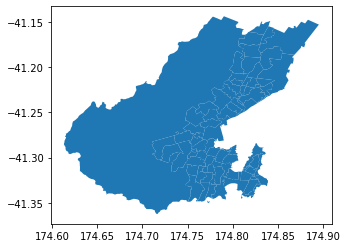

In [28]:
wel_geodf.plot()

Conversion to GeoJSON

In [29]:
wel_geojson = wel_geodf.to_json()

##### Completing information of the Victimisations - Census grouped DataFrame

In the previous Victimisations - Census grouped DataFrame, we didn't had the coordinates of the Area Unit Wellington City-Marinas. Now, we can retrieve them:

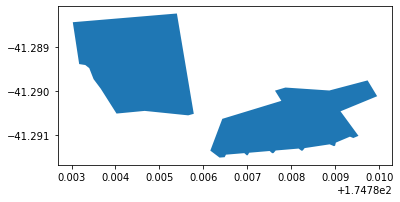

In [30]:
marinas = wel_geodf[wel_geodf['Area_Unit']=='Wellington City-Marinas']
marinas.plot()

By simple observation, we can estimate the mean coordinates of this Area Unit.

In [31]:
grouped_df.loc[3,'Latitude'] = -41.290
grouped_df.loc[3,'Longitude']= 174.7860

We verify that the dataframe does not have any NaN values.

In [32]:
grouped_df.isna().any()

Area Unit                                False
Latitude                                 False
Longitude                                False
Number of Victimisations                 False
Median household income (2001)           False
Median household income (2006)           False
Median household income (2013)           False
AVG Median household income 2001-2013    False
dtype: bool

#### Now, all of our data has been retrieved into:
* One table containing information on the Suburbs of Wellington (Coordinates and Mean house prices)
* One table containing information on the Area Units of Wellington (Coordinates, Victimisations, Median household income)
* One GeoJSON file containing the bondaries of the Area Units of Wellington

##### As mentionned in the introduction, we want to analyse Wellington in function of its suburbs. That's why we would like to obtain one table containing the data Coordinates, Mean house prices, Victimisations, Median household income as function of the Suburbs in a Master DataFrame

## Getting the Master DataFrame

### Associating the Area Units with the Suburbs

We want to associate each Area Unit with a Suburb. To do that, we associate to each Area Unit the Suburb at the minimum distance with it using their coordinates.

First, we calculate the distance matrix as follow:

In [33]:
Lat_squared_error = (np.array([grouped_df['Latitude'] for i in range(wellington_df.shape[0])]).T \
                     - np.array(wellington_df['Latitude']).reshape(1,wellington_df.shape[0]))**2
Long_squared_error = (np.array([grouped_df['Longitude'] for i in range(wellington_df.shape[0])]).T \
                     - np.array(wellington_df['Longitude']).reshape(1,wellington_df.shape[0]))**2

Distance = np.sqrt(Lat_squared_error + Long_squared_error)

Then, we get the closest suburb of each Area Unit as follow:

In [34]:
Suburb_idx = Distance.argmin(axis = 1)
grouped_df['Suburb'] = list(wellington_df.loc[Suburb_idx,'Suburb'])

Here is the DataFrame relating Area Unit and Suburb:

In [35]:
grouped_df.head()

,Area Unit,Latitude,Longitude,Number of Victimisations,Median household income (2001),Median household income (2006),Median household income (2013),AVG Median household income 2001-2013,Suburb
0,Woodridge,-41.218523,174.830970,55,69500.0,86900.0,106500.0,87633,Woodridge
1,Wilton,-41.269440,174.758841,170,57000.0,74400.0,91000.0,74133,Wilton
2,Willis Street-Cambridge Terrace,-41.293222,174.779453,11387,71900.0,83000.0,86100.0,80333,Te aro
3,Wellington City-Marinas,-41.290000,174.786000,24,100000.0,60000.0,75000.0,78333,Mount victoria
4,Wadestown,-41.261589,174.774328,565,94800.0,100000.0,135600.0,110133,Wadestown


### Getting the data on Victimisations and Median household income per Suburb

We group the above DataFrame by Suburb using the average values.

In [36]:
grouped_df_sub = grouped_df.iloc[:,3:].groupby('Suburb').mean()
print('Shape of the resulting DataFrame:', grouped_df_sub.shape)
grouped_df_sub.head()

Shape of the resulting DataFrame: (47, 5)


,Number of Victimisations,Median household income (2001),Median household income (2006),Median household income (2013),AVG Median household income 2001-2013
Suburb,,,,,
Aro valley,1026.0,34900.0,41900.0,62300.0,46366.0
Berhampore,367.5,36250.0,47400.0,63350.0,48999.5
Breaker bay,158.0,77200.0,100000.0,136300.0,104500.0
Broadmeadows,249.0,69000.0,81400.0,100500.0,83633.0
Brooklyn,295.0,68100.0,82800.0,107800.0,86233.0


We can see that some suburbs were not associated with any Area Unit. That's a problem we will solve next.

First, we can join this DataFrame with the DataFrame containing the information on the Suburbs to get the Master DataFrame.

In [37]:
wellington_ms_df = wellington_df.join(grouped_df_sub, on = 'Suburb', how = 'left')
wellington_ms_df.head()

,Ward,Suburb,MEDIAN HOUSE PRICE (NZD),Latitude,Longitude,Number of Victimisations,Median household income (2001),Median household income (2006),Median household income (2013),AVG Median household income 2001-2013
0,Northern Ward,Churton park,835393.0,-41.208938,174.807138,128.000000,69500.000000,88000.000000,99600.000000,85700.000000
1,Northern Ward,Glenside,513324.0,-41.206097,174.812459,125.500000,72500.000000,82800.000000,112650.000000,89316.500000
2,Northern Ward,Grenada north,502478.0,-41.186205,174.837951,109.000000,47500.000000,64300.000000,68300.000000,60033.000000
3,Northern Ward,Horokiwi,823228.0,-41.200949,174.845982,NaN,NaN,NaN,NaN,NaN
4,Northern Ward,Johnsonville,674993.0,-41.220339,174.802761,690.666667,55733.333333,68366.666667,85633.333333,69910.666667


The DataFram contains NaN values for the reason mentionned above.

Fill the NaN value by the average per Ward

In [38]:
avg_ward_df = wellington_ms_df.groupby('Ward').mean()
avg_ward_df

,MEDIAN HOUSE PRICE (NZD),Latitude,Longitude,Number of Victimisations,Median household income (2001),Median household income (2006),Median household income (2013),AVG Median household income 2001-2013
Ward,,,,,,,,
Eastern Ward,920422.307692,-41.317588,174.811418,616.033333,58658.333333,74003.333333,94886.666667,75849.083333
Lambton Ward,852424.100000,-41.289269,174.775382,2689.312500,64629.166667,73229.166667,86439.583333,74765.687500
Northern Ward,667129.272727,-41.202989,174.824079,249.516667,62483.333333,75900.000000,93923.333333,77435.200000
Onslow-Western Ward,845805.923077,-41.250088,174.764468,294.378788,71900.000000,84739.393939,107546.969697,84545.121212
Southern Ward,810037.300000,-41.323814,174.771680,368.562500,54475.000000,69237.500000,86925.000000,70212.125000


In [39]:
for i in wellington_ms_df[wellington_ms_df.isna().sum(axis=1)>=1].index:
    wellington_ms_df.iloc[i,5:]=avg_ward_df.loc[wellington_ms_df['Ward'][i],['Number of Victimisations',\
                                                                 'Median household income (2001)',\
                                                       'Median household income (2006)',\
                                                       'Median household income (2013)',\
                                                      'AVG Median household income 2001-2013']]

We reorganize the columns

In [40]:
reindexed_columns= ['Ward','Suburb', 'Latitude', 'Longitude', 'Median household income (2001)',\
                    'Median household income (2006)', 'Median household income (2013)', \
                    'AVG Median household income 2001-2013', 'MEDIAN HOUSE PRICE (NZD)',\
                    'Number of Victimisations']

wellington_ms_df = wellington_ms_df.reindex(reindexed_columns, axis=1)
wellington_ms_df.head()

,Ward,Suburb,Latitude,Longitude,Median household income (2001),Median household income (2006),Median household income (2013),AVG Median household income 2001-2013,MEDIAN HOUSE PRICE (NZD),Number of Victimisations
0,Northern Ward,Churton park,-41.208938,174.807138,69500.000000,88000.000000,99600.000000,85700.000000,835393.0,128.000000
1,Northern Ward,Glenside,-41.206097,174.812459,72500.000000,82800.000000,112650.000000,89316.500000,513324.0,125.500000
2,Northern Ward,Grenada north,-41.186205,174.837951,47500.000000,64300.000000,68300.000000,60033.000000,502478.0,109.000000
3,Northern Ward,Horokiwi,-41.200949,174.845982,62483.333333,75900.000000,93923.333333,77435.200000,823228.0,249.516667
4,Northern Ward,Johnsonville,-41.220339,174.802761,55733.333333,68366.666667,85633.333333,69910.666667,674993.0,690.666667


## Wellington Venues Data using Foursquare API

Credential:

In [41]:
# Foursquare API credential
CLIENT_ID = 'WVT12QBAKTKN1TAOG2LC5Z2SM55XRKZB3YMGLUFUXNB3DYT4' # your Foursquare ID
CLIENT_SECRET = 'R5I2ONWLBHXOOEQ5WW5WO4EQOBYTYPPK44ARQKRNCMVQF2G1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Define the function to get the nearby venues of each suburb's coordinates

In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius=750, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in tqdm(zip(names, latitudes, longitudes)):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Getting the nearby venues:

In [43]:
wellington_venues = getNearbyVenues(names = wellington_ms_df['Suburb'],
                                   latitudes = wellington_ms_df['Latitude'],
                                   longitudes = wellington_ms_df['Longitude']
                                  )
print('Venues Collected!')
print('Number of venues collected: ', wellington_venues.shape[0])

57it [00:37,  1.50it/s]

Venues Collected!
Number of venues collected:  919


Save the collected DataFrame to a CSV file

In [44]:
wellington_venues.to_csv('data/wellington_venues.csv')

Display the collected DataFrame

In [45]:
wellington_venues.head()

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Churton park,-41.208938,174.807138,Simmer,-41.202634,174.807853,Café
1,Churton park,-41.208938,174.807138,Cafe Thyme,-41.205843,174.812013,Café
2,Churton park,-41.208938,174.807138,New World,-41.203018,174.807914,Supermarket
3,Churton park,-41.208938,174.807138,Twigland Gardeners World,-41.205633,174.812385,Garden Center
4,Churton park,-41.208938,174.807138,Takeaways @ Churton,-41.202432,174.807862,Fish & Chips Shop


Rearranging the data using dummy variables for the venues'categories

In [46]:
wellington_onehot = pd.get_dummies(wellington_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
wellington_onehot['Suburb'] = wellington_venues['Suburb'] 

# move neighborhood column to the first column
fixed_columns = [wellington_onehot.columns[-1]] + list(wellington_onehot.columns[:-1])
wellington_onehot = wellington_onehot[fixed_columns]
wellington_onehot.head()

,Suburb,Airport,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Tree,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Zoo
0,Churton park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Churton park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Churton park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Churton park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Churton park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's group by Suburb

In [47]:
wellington_grouped = wellington_onehot.groupby('Suburb').sum().reset_index()
wellington_grouped.head()

,Suburb,Airport,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Tree,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Zoo
0,Aro valley,0,0,0,1,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
1,Berhampore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Breaker bay,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Broadmeadows,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Brooklyn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Let's check if we collected at least one venues for all the suburbs:

In [48]:
print(wellington_grouped.shape)
print(wellington_ms_df.shape)

(55, 181)
(57, 10)


There is two suburbs that did get any venues associated with them. We find them:

In [49]:
suburb_wo_venues_truth_table = ~wellington_ms_df['Suburb'].isin(wellington_grouped['Suburb']).to_frame()
wellington_ms_df[suburb_wo_venues_truth_table['Suburb']]

,Ward,Suburb,Latitude,Longitude,Median household income (2001),Median household income (2006),Median household income (2013),AVG Median household income 2001-2013,MEDIAN HOUSE PRICE (NZD),Number of Victimisations
19,Onslow-Western Ward,Ohariu,-41.193061,174.754987,71900.0,84739.393939,107546.969697,84545.121212,823228.0,294.378788
56,Onslow-Western Ward,Makara,-41.251169,174.713663,62000.0,85000.000000,101600.000000,82866.000000,598436.0,95.000000


Going on the foursquare website and doing the search manually, we can collect some venues for these suburbs.

In [50]:
Ohariu_row = {'Suburb': 'Ohariu'}
Makara_row = {'Suburb': 'Makara' }

for col in wellington_grouped.columns[1:]:
    Ohariu_row[col]=0
    Makara_row[col]=0
# Search on foursquare for 'Makara' and 'Ohariu'
Ohariu_row['Home Services'] = 1 
Ohariu_row['Scenic Lookout'] = 1
Ohariu_row['Mountain'] = 1
Ohariu_row['Train'] = 1
Makara_row['Beach'] = 1
Makara_row['Trail'] = 1
Makara_row['Scenic Lookout'] = 1
Makara_row['Park'] = 1

In [51]:
wellington_grouped = wellington_grouped.append(Ohariu_row, ignore_index=True)
wellington_grouped = wellington_grouped.append(Makara_row, ignore_index=True)
wellington_grouped.reset_index(drop = True)
wellington_grouped.replace(np.nan, 0, inplace = True)

Let's verify that we have indeed 57 suburbs now:

In [52]:
print(wellington_grouped.shape)
wellington_grouped.head()

(57, 183)


,Suburb,Airport,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Zoo,Home Services,Train
0,Aro valley,0,0,0,1,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0.0,0.0
1,Berhampore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
2,Breaker bay,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
3,Broadmeadows,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
4,Brooklyn,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.0,0.0


We get the total number of venues for each suburb:

In [53]:
wellington_grouped['Nb Venues'] = wellington_grouped.iloc[:,1:].sum(axis = 1)

Here is the final Venues Dataframe:

In [54]:
reindexed_columns = [wellington_grouped.columns.values[0], wellington_grouped.columns.values[-1]]
reindexed_columns.extend(list(wellington_grouped.columns.values[1:-1]))
reindexed_columns
wellington_grouped = wellington_grouped.reindex(reindexed_columns, axis=1)
wellington_grouped.head()

,Suburb,Nb Venues,Airport,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Zoo,Home Services,Train
0,Aro valley,62.0,0,0,0,1,0,0,0,1,...,0,1,1,0,0,0,0,0,0.0,0.0
1,Berhampore,6.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
2,Breaker bay,5.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
3,Broadmeadows,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
4,Brooklyn,11.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.0,0.0


## Wellington French Restaurants Data using Foursquare API

We define a function to collect the French restaurants for each Suburb

In [55]:
def getNearbyFrenchRestaurants(names, latitudes, longitudes, radius=1250, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in tqdm(zip(names, latitudes, longitudes)):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query=French%20Restaurant&radius={}&limit=30'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_french_restaurants = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_french_restaurants.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_french_restaurants)

Getting the French restaurants:

In [56]:
wellington_french_restaurants = getNearbyFrenchRestaurants(names = wellington_ms_df['Suburb'],
                                   latitudes = wellington_ms_df['Latitude'],
                                   longitudes = wellington_ms_df['Longitude']
                                  )
print('French Restaurants Collected!')
print('Number of French Restaurants collected: ', wellington_french_restaurants['Venue'].unique().size)

57it [00:33,  1.73it/s]

French Restaurants Collected!
Number of French Restaurants collected:  10


Saving to a CSV file

In [57]:
wellington_french_restaurants.to_csv('data/wellington_french_restaurants.csv')

Here is the collected DataFrame listing the French restaurants of Wellington:

In [58]:
wellington_french_restaurants.head()

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Newlands,-41.223116,174.822234,my french larder,-41.222212,174.820358,French Restaurant
1,Paparangi,-41.214825,174.816750,my french larder,-41.222212,174.820358,French Restaurant
2,Woodridge,-41.216469,174.832599,my french larder,-41.222212,174.820358,French Restaurant
3,Northland,-41.282339,174.757356,Aubergine,-41.278310,174.769842,French Restaurant
4,Wadestown,-41.264715,174.779077,Le Marche Francais,-41.268654,174.781331,French Restaurant


## Summary:


##### Reminder of the DataFrames we have collected for our study

### Three main DataFrames

A Master DataFrame regrouping all the numbers of the suburbs and their coordinates:

In [59]:
wellington_ms_df.sort_values('Suburb', inplace = True)
wellington_ms_df.reset_index(drop = True, inplace = True)
wellington_ms_df.head()

,Ward,Suburb,Latitude,Longitude,Median household income (2001),Median household income (2006),Median household income (2013),AVG Median household income 2001-2013,MEDIAN HOUSE PRICE (NZD),Number of Victimisations
0,Lambton Ward,Aro valley,-41.295328,174.766580,34900.0,41900.0,62300.0,46366.0,769875.0,1026.0
1,Southern Ward,Berhampore,-41.323264,174.774090,36250.0,47400.0,63350.0,48999.5,769112.0,367.5
2,Eastern Ward,Breaker bay,-41.334316,174.827818,77200.0,100000.0,136300.0,104500.0,987443.0,158.0
3,Onslow-Western Ward,Broadmeadows,-41.233961,174.796556,69000.0,81400.0,100500.0,83633.0,717413.0,249.0
4,Southern Ward,Brooklyn,-41.306574,174.762354,68100.0,82800.0,107800.0,86233.0,853524.0,295.0


A Venue DataFrame regrouping the type and number of venues per suburb

In [60]:
wellington_grouped.sort_values('Suburb', inplace = True)
wellington_grouped.reset_index(drop = True, inplace = True)
wellington_grouped.head()

,Suburb,Nb Venues,Airport,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Zoo,Home Services,Train
0,Aro valley,62.0,0,0,0,1,0,0,0,1,...,0,1,1,0,0,0,0,0,0.0,0.0
1,Berhampore,6.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
2,Breaker bay,5.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
3,Broadmeadows,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
4,Brooklyn,11.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.0,0.0


A French Restaurants DataFrame regrouping the information on the French Restaurants and to which suburbs they can be associated with (a restaurant can be associated with several suburbs).

In [61]:
wellington_grouped.sort_values('Suburb', inplace = True)
wellington_grouped.reset_index(drop = True, inplace = True)
wellington_french_restaurants.head()

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Newlands,-41.223116,174.822234,my french larder,-41.222212,174.820358,French Restaurant
1,Paparangi,-41.214825,174.816750,my french larder,-41.222212,174.820358,French Restaurant
2,Woodridge,-41.216469,174.832599,my french larder,-41.222212,174.820358,French Restaurant
3,Northland,-41.282339,174.757356,Aubergine,-41.278310,174.769842,French Restaurant
4,Wadestown,-41.264715,174.779077,Le Marche Francais,-41.268654,174.781331,French Restaurant


### Two secondary DataFrames for Visualisation

A DataFrame similar with the Master DataFrame without the Median House Price regrouping the information per Area Unit

In [62]:
grouped_df.sort_values('Area Unit', inplace = True)
grouped_df.reset_index(drop = True, inplace = True)
grouped_df.head()

,Area Unit,Latitude,Longitude,Number of Victimisations,Median household income (2001),Median household income (2006),Median household income (2013),AVG Median household income 2001-2013,Suburb
0,Adelaide,-41.305659,174.781208,777,49000.0,56400.0,77100.0,60833,Newtown
1,Aro Street-Nairn Street,-41.297543,174.766615,1026,34900.0,41900.0,62300.0,46366,Aro valley
2,Awarua,-41.245644,174.772456,141,79500.0,95100.0,114800.0,96466,Ngaio
3,Berhampore East,-41.325441,174.778989,161,34200.0,47700.0,65000.0,48966,Berhampore
4,Berhampore West,-41.321378,174.772730,574,38300.0,47100.0,61700.0,49033,Berhampore


A GeoDataFrame used to create a GeoJSON defining the bondaries of each Area Unit

In [63]:
wel_geodf.sort_values('Area_Unit', inplace = True)
wel_geodf.reset_index(drop = True, inplace = True)
wel_geodf.head()

/Users/MathiasW/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Area_Unit,AREA_SQ_KM,LAND_AREA_SQ_KM,Shape_Length,geometry
0,Adelaide,0.55070587,0.55070587,3727.0815348,"MULTIPOLYGON (((174.78115 -41.30173, 174.78118..."
1,Aro Street-Nairn Street,0.83471214,0.83471214,4680.84303778,"MULTIPOLYGON (((174.76561 -41.29179, 174.76582..."
2,Awarua,1.89262252,1.89262252,8022.9525123,"MULTIPOLYGON (((174.77740 -41.23958, 174.77708..."
3,Berhampore East,0.39264193,0.39264193,3747.31465598,"MULTIPOLYGON (((174.78029 -41.32338, 174.78027..."
4,Berhampore West,0.96611582,0.96611582,5311.92754373,"MULTIPOLYGON (((174.77805 -41.31656, 174.77796..."


# Exploratory Data Analysis


In this section, we analyze and visualise our data to better understand it .

### Map of Wellington

Let's first visualise Wellington and the position of its suburbs (*blue*) and the French restaurants (*red*) on a map.

In [64]:
map_wellington = folium.Map(location=[latitude_wel, longitude_wel], zoom_start=11)

# add markers to map
for lat, lng, ward, suburb in zip(wellington_ms_df['Latitude'], wellington_ms_df['Longitude'],\
                                      wellington_ms_df['Ward'],  wellington_ms_df['Suburb']):
    label = '{}, {}'.format(ward, suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_wellington)  
 
for lat, lng, name in zip(wellington_french_restaurants['Venue Latitude'], \
                          wellington_french_restaurants['Venue Longitude'],\
                          wellington_french_restaurants['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_wellington)  

map_wellington

### Median House Price & Median Household Income

Let's visualize the distribution of the median house price per suburb and the suburbs with the highest median house price.

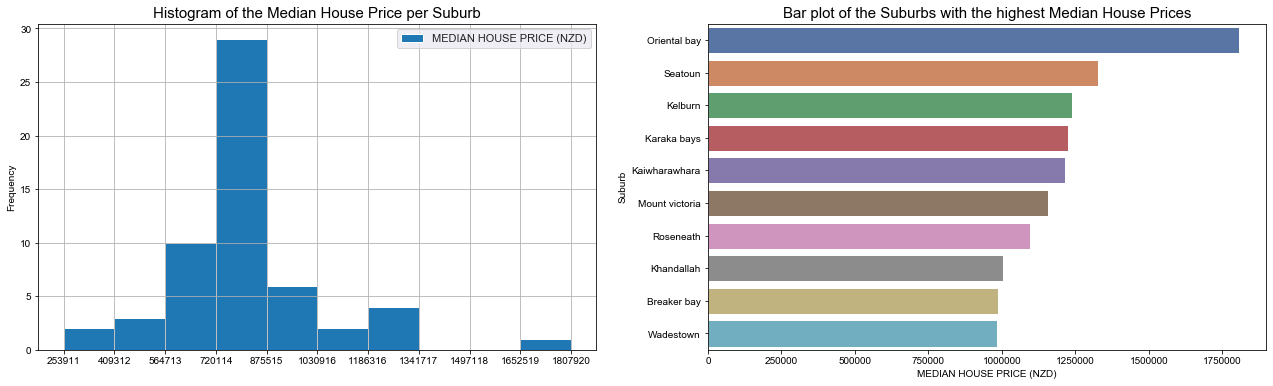

In [65]:
fig, axes = plt.subplots(1,2, figsize = (22, 6))

sns.set()

count, bin_edges = np.histogram(wellington_ms_df['MEDIAN HOUSE PRICE (NZD)'])

wellington_ms_df[['MEDIAN HOUSE PRICE (NZD)']].plot(kind ='hist', ax = axes[0], xticks=bin_edges)

sns.catplot(y = "Suburb", x = "MEDIAN HOUSE PRICE (NZD)", kind = "bar",\
                data = wellington_ms_df.sort_values('MEDIAN HOUSE PRICE (NZD)',\
                                                    ascending = False).head(10), ax=axes[1])
axes[0].set_title('Histogram of the Median House Price per Suburb', size=15)
axes[1].set_title('Bar plot of the Suburbs with the highest Median House Prices', size=15)
plt.close(2)
plt.show()

We observe that the house price is generally distributed around 800,000 NZD. Nonetheless, one suburb as a particuliary high median house price: 'Oriental Bay'

Let's visualize the distribution of the median household income per suburb and the suburbs with the highest median household income.

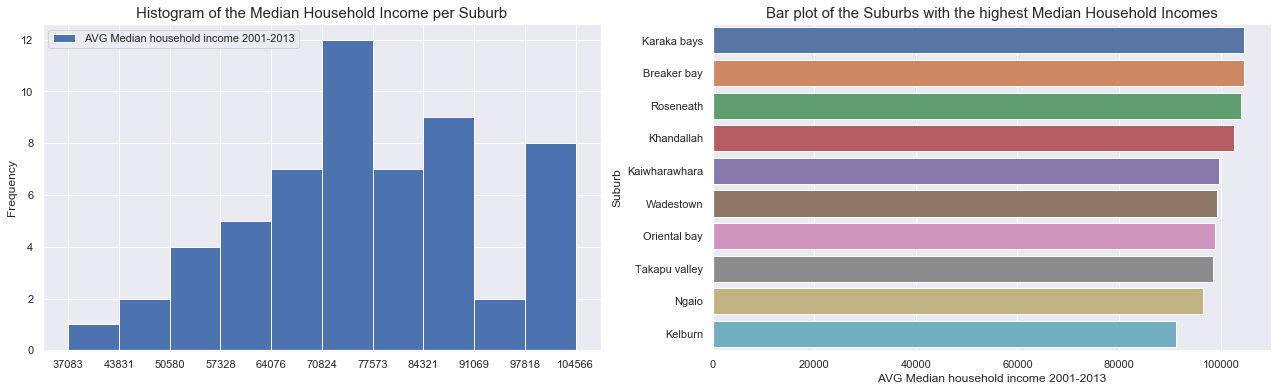

In [66]:
fig, axes = plt.subplots(1,2, figsize = (22, 6))

count, bin_edges = np.histogram(wellington_ms_df['AVG Median household income 2001-2013'])

wellington_ms_df[['AVG Median household income 2001-2013']].plot(kind = 'hist', ax = axes[0], xticks=bin_edges)
sns.catplot(y = "Suburb", x = "AVG Median household income 2001-2013", kind = "bar",\
                data = wellington_ms_df.sort_values('AVG Median household income 2001-2013',\
                                                    ascending = False).head(10), ax = axes[1]);

axes[0].set_title('Histogram of the Median Household Income per Suburb', size=15)
axes[1].set_title('Bar plot of the Suburbs with the highest Median Household Incomes', size=15)
plt.close(2)
plt.show()

Let's study the correlation of the two datasets:

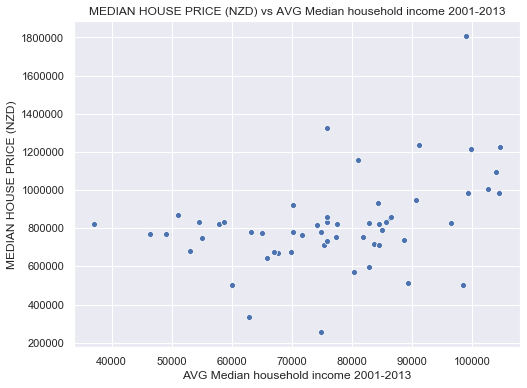

In [67]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x = 'AVG Median household income 2001-2013', y = 'MEDIAN HOUSE PRICE (NZD)',\
                data = wellington_ms_df, ax = ax)
ax.set_title('MEDIAN HOUSE PRICE (NZD) vs AVG Median household income 2001-2013')
plt.show()

From this plot, the two looks somewhat correlated but it seems complicated to draw a clear correlation.

Let's get the Pearson Correlation and the P-value. 

As a reminder:
<p>The Pearson Correlation measures the linear dependence between two variables X and Y. The resulting coefficient is a value between -1 and 1 inclusive, where:</p>
<ul>
    <li><b>1</b>: Total positive linear correlation.</li>
    <li><b>0</b>: No linear correlation, the two variables most likely do not affect each other.</li>
    <li><b>-1</b>: Total negative linear correlation.</li>
</ul>

The P-value is the probability value that the correlation between these two variables is statistically significant. Normally, we choose a significance level of 0.05, which means that we are 95% confident that the correlation between the variables is significant. By convention, when the</p> 
<ul>
    <li>p-value is $<$ 0.001: we say there is strong evidence that the correlation is significant.</li>
    <li>the p-value is $<$ 0.05: there is moderate evidence that the correlation is significant.</li>
    <li>the p-value is $<$ 0.1: there is weak evidence that the correlation is significant.</li>
    <li>the p-value is $>$ 0.1: there is no evidence that the correlation is significant.</li>
</ul>

In [68]:
pearson_coef, p_value = stats.pearsonr(wellington_ms_df['MEDIAN HOUSE PRICE (NZD)'],\
                                       wellington_ms_df['AVG Median household income 2001-2013'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value ) 

The Pearson Correlation Coefficient is 0.389721242982697  with a P-value of P = 0.0027300527575398964


Since we have: 0.001 < P-value < 0.05, there is moderate evidence that the correlation is significant. We could have thought that the correlation would have been more significant.

##### Median Household income versus Number of Venues

The Pearson Correlation Coefficient is -0.2012072776519616  with a P-value of P = 0.13340135787521945


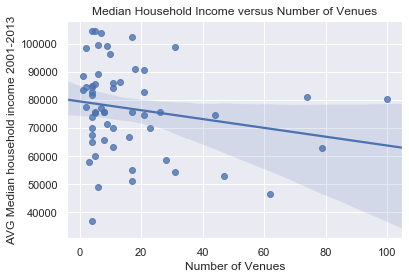

In [69]:
sns.regplot(x = wellington_grouped['Nb Venues'], y = wellington_ms_df['AVG Median household income 2001-2013'])
plt.xlabel('Number of Venues')
plt.title('Median Household Income versus Number of Venues')
pearson_coef, p_value = stats.pearsonr(wellington_grouped['Nb Venues'], wellington_ms_df['AVG Median household income 2001-2013'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value ) 

There is no evidence of correlation.

##### Median House Price versus Number of Venues

The Pearson Correlation Coefficient is -0.07632068838225133  with a P-value of P = 0.5725724813638574


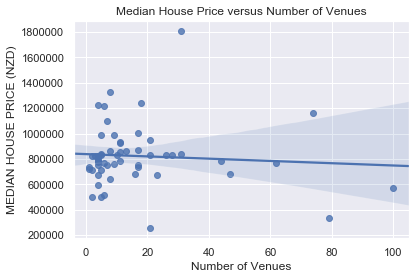

In [70]:
sns.regplot(x = wellington_grouped['Nb Venues'], y = wellington_ms_df['MEDIAN HOUSE PRICE (NZD)'])
plt.xlabel('Number of Venues')
plt.title('Median House Price versus Number of Venues')

pearson_coef, p_value = stats.pearsonr(wellington_grouped['Nb Venues'], wellington_ms_df['MEDIAN HOUSE PRICE (NZD)'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value ) 

There is no evidence of correlation.

### Number of Victimisations & Number of Venues

Let's visualize the distribution of the number of victimisation and the suburbs with the most victimisations recorded.

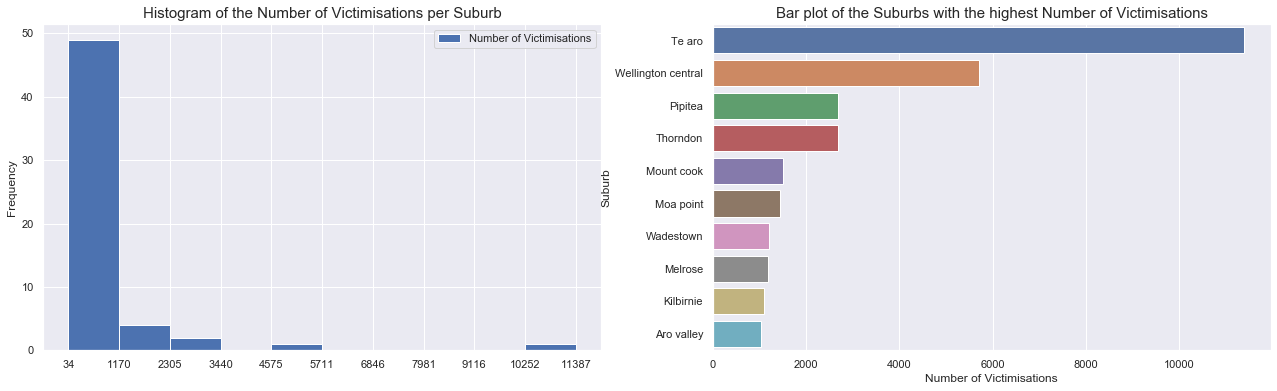

In [71]:
fig, axes = plt.subplots(1,2, figsize = (22, 6))

count, bin_edges = np.histogram(wellington_ms_df['Number of Victimisations'])

wellington_ms_df[['Number of Victimisations']].plot(kind = 'hist', ax = axes[0], xticks=bin_edges)
sns.catplot(y = "Suburb", x = "Number of Victimisations", kind = "bar",\
                data = wellington_ms_df.sort_values('Number of Victimisations',\
                                                    ascending = False).head(10), ax= axes[1]);

axes[0].set_title('Histogram of the Number of Victimisations per Suburb', size=15)
axes[1].set_title('Bar plot of the Suburbs with the highest Number of Victimisations', size=15)

plt.close(2)
plt.show()

Let's visualize the distribution of the number of venues and the suburbs with the most venues.

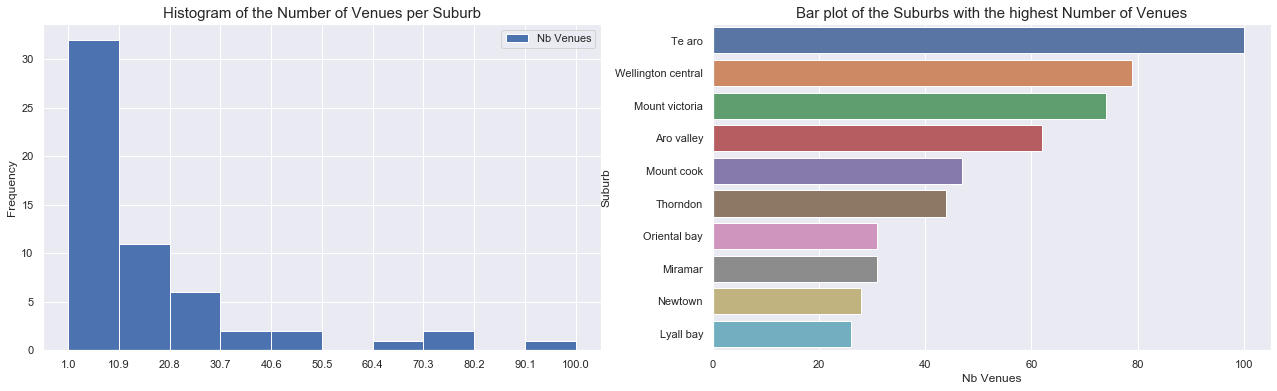

In [72]:
fig, axes = plt.subplots(1,2, figsize = (22, 6))

count, bin_edges = np.histogram(wellington_grouped['Nb Venues'])

wellington_grouped[['Nb Venues']].plot(kind = 'hist', ax=axes[0], xticks=bin_edges)
sns.catplot(y = "Suburb", x = "Nb Venues", kind = "bar",\
                data = wellington_grouped.sort_values('Nb Venues', ascending = False).head(10), ax=axes[1])

axes[0].set_title('Histogram of the Number of Venues per Suburb', size=15)
axes[1].set_title('Bar plot of the Suburbs with the highest Number of Venues', size=15)

plt.close(2)
plt.show()

The two distributions are looking similar. Let's plot the two datasets in function of each other.

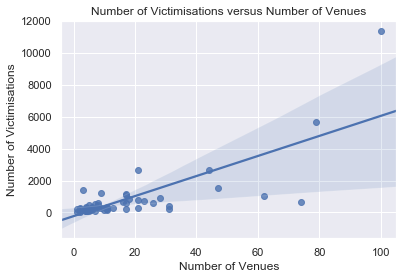

In [73]:
sns.regplot(x = wellington_grouped['Nb Venues'], y = wellington_ms_df['Number of Victimisations'])
plt.title('Number of Victimisations versus Number of Venues')
plt.xlabel('Number of Venues')
plt.show()

Let's get the Pearson Correlation and the P-value.

In [74]:
pearson_coef, p_value = stats.pearsonr(wellington_grouped['Nb Venues'], wellington_ms_df['Number of Victimisations'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value ) 

The Pearson Correlation Coefficient is 0.7630407218684434  with a P-value of P = 5.219969564953219e-12


The P-value being less than 0.001, there is a strong evidence that the correlation is significant. This is logical as you expect the places having the most venues being places where victimisations are more likely to happen as they are  more venues to steal from and they would concentrate a higher density of people in the street.

As we can see on the map and as a rapid search on internet reveals, the place with the most venues and the most victimisations, Te Aro, is in the city center and "is New Zealand's largest entertainment district and thrives at night" (source : Wikipedia Page of Te Aro). This clearly explains the particular high volume of victimisations and venues

### Number of Restaurants & French Restaurants

First, we get the restaurants and their numbers per suburb:

In [75]:
'Restaurant' in wellington_grouped.columns.values
idx = [0]
for i in range(1,wellington_grouped.columns.size):
    if 'Restaurant' in wellington_grouped.columns.values[i]:
        idx.append(i)


In [76]:
wellington_restaurants = wellington_grouped.iloc[:,idx]
wellington_restaurants['Nb Restaurants'] = wellington_restaurants.iloc[:,1:].sum( axis = 1)
wellington_restaurants = wellington_restaurants[wellington_restaurants['Nb Restaurants'] != 0]
wellington_restaurants.head()

/Users/MathiasW/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Suburb,American Restaurant,Argentinian Restaurant,Asian Restaurant,Cambodian Restaurant,Chinese Restaurant,Dumpling Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,...,Restaurant,Seafood Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Nb Restaurants
0,Aro valley,0,1,1,0,0,0,0,0,0,...,3,0,0,0,0,0,0,1,0,14
4,Brooklyn,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
10,Hataitai,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,4
11,Highbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14,Island bay,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [77]:
wellington_french_restaurants_nb = wellington_french_restaurants.groupby('Suburb').count()['Venue'].to_frame().reset_index()
wellington_french_restaurants_nb.columns=['Suburb','Number of French Restaurants']

Let's plot the bar plots of the Number of Restaurants and Number of French Restaurants per Suburb

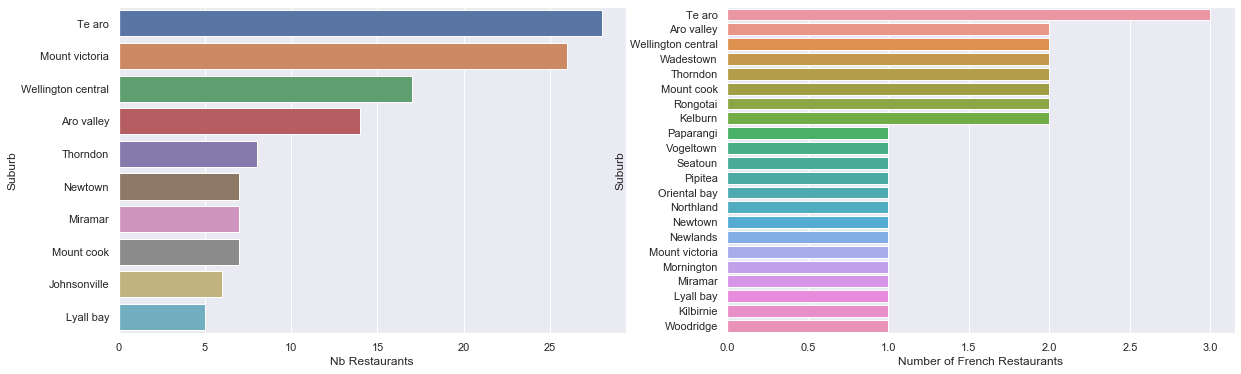

In [78]:
fig, axes = plt.subplots(1,2, figsize = (20, 6))

sns.catplot(y = "Suburb", x = "Nb Restaurants", kind = "bar",\
                data = wellington_restaurants.sort_values('Nb Restaurants',\

                                                          ascending = False).head(10), ax = axes[0]);

sns.catplot(x='Number of French Restaurants', y ='Suburb', kind = 'bar',\
            data = wellington_french_restaurants_nb.sort_values('Number of French Restaurants',\
                                                                ascending = False), ax = axes[1])

plt.close(2)
plt.close(3)
plt.show()

We can see that without surprise, Te Aro and the other central suburbs have the most restaurants. Moreover, a suburb does not have more than three French restaurants and the only suburb having three of them is Te Aro.

Let's look at the correlation between the Number of French Restaurants, Restaurants and Venues:

We regroup all the numbers in one table.

In [79]:
wel_fr_v = wellington_french_restaurants_nb.join( wellington_grouped.set_index('Suburb'), on = 'Suburb', how ='right')
wel_fr_r_v = wellington_restaurants[['Suburb','Nb Restaurants']].join( wel_fr_v.set_index('Suburb'), on = 'Suburb', how ='right')
wel_fr_r_v = wel_fr_r_v.replace(np.nan, 0).iloc[:,:4]
wel_fr_r_v.sort_values('Suburb', ascending = True, inplace = True)
wel_fr_r_v.reset_index(drop = True, inplace = True)

wel_fr_r_v.head()

,Suburb,Nb Restaurants,Number of French Restaurants,Nb Venues
0,Aro valley,14.0,2.0,62.0
1,Berhampore,0.0,0.0,6.0
2,Breaker bay,0.0,0.0,5.0
3,Broadmeadows,0.0,0.0,1.0
4,Brooklyn,1.0,0.0,11.0


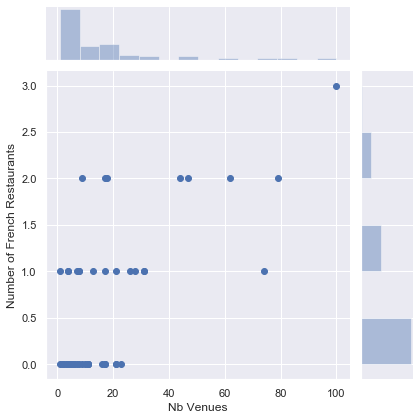

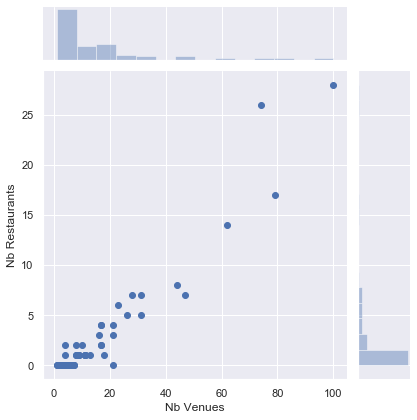

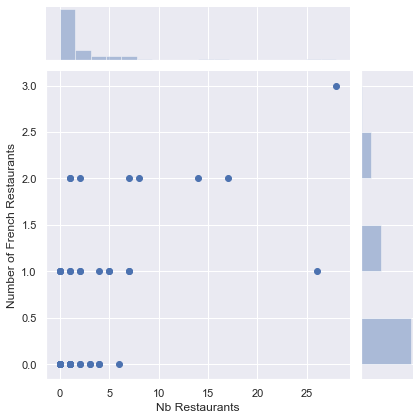

In [80]:
sns.jointplot(x = 'Nb Venues', y = 'Number of French Restaurants', data = wel_fr_r_v)
plt.show()
sns.jointplot(x = 'Nb Venues', y = 'Nb Restaurants', data = wel_fr_r_v)
plt.show()
sns.jointplot(x = 'Nb Restaurants', y = 'Number of French Restaurants', data = wel_fr_r_v)
plt.show()

We can observe that each time the datasets are somewhat positively correlated, which is logical.

### Most common venues per Suburb

Let's analyse what are the most common venues of each Suburb which gives us a feel of the ambiance of each of them.

In [81]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [82]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
suburbs_venues_sorted = pd.DataFrame(columns=columns)
suburbs_venues_sorted['Suburb'] = wellington_grouped['Suburb']

for ind in np.arange(wellington_grouped.shape[0]):
    suburbs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(wellington_grouped.iloc[ind, :], num_top_venues)

print('Shape is', suburbs_venues_sorted.shape)
suburbs_venues_sorted.head()

Shape is (57, 11)


,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aro valley,Café,Bar,Coffee Shop,Italian Restaurant,Restaurant,Pizza Place,Fish Market,Burger Joint,Brewery,Bakery
1,Berhampore,Park,Recreation Center,Laundromat,Skate Park,Hockey Arena,Electronics Store,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
2,Breaker bay,Playground,Smoke Shop,Beach,Scenic Lookout,Nudist Beach,Train,Exhibit,Food,Fish Market,Fish & Chips Shop
3,Broadmeadows,Train Station,Train,Food & Drink Shop,Food,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Exhibit
4,Brooklyn,Convenience Store,Pie Shop,Fast Food Restaurant,Gastropub,Burger Joint,Park,Pharmacy,Café,Deli / Bodega,Indie Movie Theater


# Data Exploitation : Finding the best suburbs to open a French Restaurant

## 1 - Clustering the Suburbs on median household income and median house price

We want to cluster the suburbs according to their median house price and their Average Median household income because we want to find suburbs where the households incomes are high enough for people to afford regularly to go to a fancy restaurant with a correct median house price for the acquisition of the building.

In [83]:
wellington_clustering = wellington_ms_df[['Suburb','AVG Median household income 2001-2013','MEDIAN HOUSE PRICE (NZD)']]
wellington_clustering.head()

,Suburb,AVG Median household income 2001-2013,MEDIAN HOUSE PRICE (NZD)
0,Aro valley,46366.0,769875.0
1,Berhampore,48999.5,769112.0
2,Breaker bay,104500.0,987443.0
3,Broadmeadows,83633.0,717413.0
4,Brooklyn,86233.0,853524.0


In [84]:
X = wellington_clustering.values[:,1:]
X_scaled = StandardScaler().fit_transform(X)

Let's find the best k for K-Means Clustering

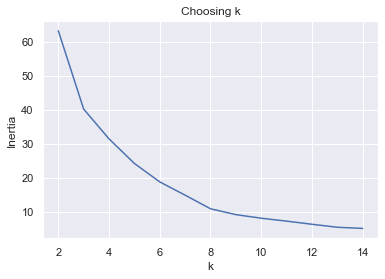

In [85]:
score_k = []
for kclusters in range(2,15):
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X_scaled)
    score_k.append(kmeans.inertia_)
plt.plot(list(range(2,15)), score_k)
plt.ylabel('Inertia')
plt.xlabel('k')
plt.title('Choosing k')
plt.show()

Using the 'elbow' method, the ideal k is 8.

In [86]:
kclusters = 8
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X_scaled)

In [87]:
wellington_clustering.insert(1, 'Cluster HP/HI', kmeans.labels_)

In [88]:
wellington_clustering.head()

,Suburb,Cluster HP/HI,AVG Median household income 2001-2013,MEDIAN HOUSE PRICE (NZD)
0,Aro valley,3,46366.0,769875.0
1,Berhampore,3,48999.5,769112.0
2,Breaker bay,5,104500.0,987443.0
3,Broadmeadows,4,83633.0,717413.0
4,Brooklyn,4,86233.0,853524.0


Let's visualise the cluster on a 2D plot

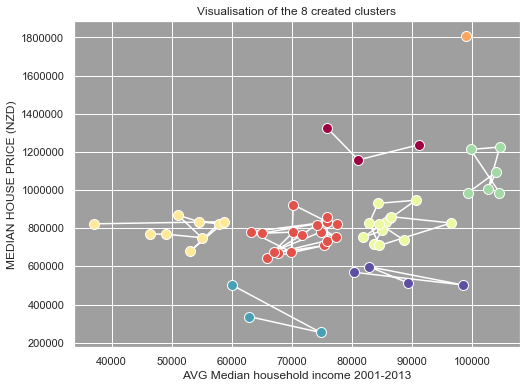

In [89]:
fig = plt.figure(figsize=(8, 6))

colours = plt.cm.Spectral(np.linspace(0, 1, len(set(kmeans.labels_))))
ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(len(kmeans.cluster_centers_)), colours):
    my_members = (kmeans.labels_ == k)
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.', markersize =20)


ax.set_title('Visualisation of the 8 created clusters')
ax.set_facecolor('#9F9F9F')
ax.set_xlabel('AVG Median household income 2001-2013')
ax.set_ylabel('MEDIAN HOUSE PRICE (NZD)')

plt.show()

Let's visualise the cluster on the map

In [90]:
# create map
map_clusters = folium.Map(location=[latitude_wel, longitude_wel], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]

colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))

rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, sub, cluster in zip(wellington_ms_df['Latitude'], wellington_ms_df['Longitude'], wellington_clustering['Suburb'], wellington_clustering['Cluster HP/HI']):
    label = folium.Popup(str(sub)+', '+ ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=label,
    color=rainbow[int(cluster)-5],
    fill=True,
    fill_color=rainbow[int(cluster)-5],
    fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 2 - Examining the previous Clusters and Selecting the one of interest

Let's create bins for the median household income and the median house price

In [91]:
income_bins = np.linspace(wellington_clustering['AVG Median household income 2001-2013'].min()-1,\
                          wellington_clustering['AVG Median household income 2001-2013'].max()+1, 6)
income_bins_labels = ['Very Low','Low','Moderate','High','Very High']
wellington_clustering['Household Income Binned'] = pd.cut(wellington_clustering['AVG Median household income 2001-2013'] ,\
                                                          bins = income_bins, labels = income_bins_labels)


price_bins = np.linspace(wellington_clustering['MEDIAN HOUSE PRICE (NZD)'].min()-1,\
                         wellington_clustering['MEDIAN HOUSE PRICE (NZD)'].max()+1, 6)
price_bins_labels = ['Very Low','Low','Moderate','High','Very High']
wellington_clustering['House Price Binned'] = pd.cut(wellington_clustering['MEDIAN HOUSE PRICE (NZD)'],\
                                                     bins = price_bins, labels = price_bins_labels)

wellington_clustering.head()

/Users/MathiasW/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/MathiasW/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Suburb,Cluster HP/HI,AVG Median household income 2001-2013,MEDIAN HOUSE PRICE (NZD),Household Income Binned,House Price Binned
0,Aro valley,3,46366.0,769875.0,Very Low,Low
1,Berhampore,3,48999.5,769112.0,Very Low,Low
2,Breaker bay,5,104500.0,987443.0,Very High,Moderate
3,Broadmeadows,4,83633.0,717413.0,High,Low
4,Brooklyn,4,86233.0,853524.0,High,Low


### Cluster 0

In [92]:
wellington_clustering[wellington_clustering['Cluster HP/HI']==0]

,Suburb,Cluster HP/HI,AVG Median household income 2001-2013,MEDIAN HOUSE PRICE (NZD),Household Income Binned,House Price Binned
19,Kelburn,0,91100.000000,1237852.0,Very High,High
32,Mount victoria,0,81049.500000,1158312.0,High,Moderate
45,Seatoun,0,75849.083333,1325884.0,Moderate,High


### Cluster 1

In [93]:
wellington_clustering[wellington_clustering['Cluster HP/HI']==1]

,Suburb,Cluster HP/HI,AVG Median household income 2001-2013,MEDIAN HOUSE PRICE (NZD),Household Income Binned,House Price Binned
12,Horokiwi,1,77435.200000,823228.0,Moderate,Low
13,Houghton bay,1,75900.000000,833281.0,Moderate,Low
14,Island bay,1,70212.125000,923323.0,Moderate,Moderate
15,Johnsonville,1,69910.666667,674993.0,Moderate,Low
22,Kingston,1,63266.000000,781363.0,Low,Low
23,Lyall bay,1,75849.083333,833121.0,Moderate,Low
26,Maupuia,1,64966.000000,773520.0,Moderate,Low
30,Mornington,1,70212.125000,780193.0,Moderate,Low
33,Newlands,1,65899.500000,644535.0,Moderate,Low
40,Owhiro bay,1,75399.500000,709858.0,Moderate,Low


### Cluster 2

In [94]:
wellington_clustering[wellington_clustering['Cluster HP/HI']==2]

,Suburb,Cluster HP/HI,AVG Median household income 2001-2013,MEDIAN HOUSE PRICE (NZD),Household Income Binned,House Price Binned
39,Oriental bay,2,98933.0,1807920.0,Very High,Very High


### Cluster 3

In [95]:
wellington_clustering[wellington_clustering['Cluster HP/HI']==3]

,Suburb,Cluster HP/HI,AVG Median household income 2001-2013,MEDIAN HOUSE PRICE (NZD),Household Income Binned,House Price Binned
0,Aro valley,3,46366.000000,769875.0,Very Low,Low
1,Berhampore,3,48999.500000,769112.0,Very Low,Low
21,Kilbirnie,3,55016.000000,750734.0,Low,Low
27,Melrose,3,51000.000000,869604.0,Low,Low
28,Miramar,3,54477.333333,834792.0,Low,Low
29,Moa point,3,57800.000000,823228.0,Low,Low
31,Mount cook,3,53100.000000,679540.0,Low,Low
34,Newtown,3,58783.000000,834517.0,Low,Low
36,Ngauranga,3,37083.000000,823228.0,Very Low,Low


### Cluster 4

In [96]:
wellington_clustering[wellington_clustering['Cluster HP/HI']==4]

,Suburb,Cluster HP/HI,AVG Median household income 2001-2013,MEDIAN HOUSE PRICE (NZD),Household Income Binned,House Price Binned
3,Broadmeadows,4,83633.000000,717413.0,High,Low
4,Brooklyn,4,86233.000000,853524.0,High,Low
5,Churton park,4,85700.000000,835393.0,High,Low
6,Crofton downs,4,85033.000000,788386.0,High,Low
9,Grenada village,4,81866.000000,752416.0,High,Low
10,Hataitai,4,90600.000000,947204.0,High,Moderate
11,Highbury,4,84311.000000,930431.0,High,Moderate
18,Karori,4,82855.333333,827991.0,High,Low
25,Makara beach,4,84545.121212,709858.0,High,Low
35,Ngaio,4,96466.000000,827701.0,Very High,Low


### Cluster 5

In [97]:
wellington_clustering[wellington_clustering['Cluster HP/HI']==5]

,Suburb,Cluster HP/HI,AVG Median household income 2001-2013,MEDIAN HOUSE PRICE (NZD),Household Income Binned,House Price Binned
2,Breaker bay,5,104500.0,987443.0,Very High,Moderate
16,Kaiwharawhara,5,99700.0,1213231.0,Very High,High
17,Karaka bays,5,104566.0,1225803.0,Very High,High
20,Khandallah,5,102611.0,1004832.0,Very High,Moderate
44,Roseneath,5,103966.0,1094849.0,Very High,Moderate
53,Wadestown,5,99199.5,984318.0,Very High,Moderate


### Cluster 6

In [98]:
wellington_clustering[wellington_clustering['Cluster HP/HI']==6]

,Suburb,Cluster HP/HI,AVG Median household income 2001-2013,MEDIAN HOUSE PRICE (NZD),Household Income Binned,House Price Binned
8,Grenada north,6,60033.0000,502478.0,Low,Very Low
42,Pipitea,6,74765.6875,253911.0,Moderate,Very Low
54,Wellington central,6,62933.0000,336855.0,Low,Very Low


### Cluster 7

In [99]:
wellington_clustering[wellington_clustering['Cluster HP/HI']==7]

,Suburb,Cluster HP/HI,AVG Median household income 2001-2013,MEDIAN HOUSE PRICE (NZD),Household Income Binned,House Price Binned
7,Glenside,7,89316.5,513324.0,High,Very Low
24,Makara,7,82866.0,598436.0,High,Low
48,Takapu valley,7,98516.5,502478.0,Very High,Very Low
50,Te aro,7,80333.0,569475.0,High,Low


From this decomposition, we can clearly see which clusters we are interested in and which we can eliminate. We want a cluster where the household income binned is at least 'High' and a correct house price binned in comparison. We are especially interested in Cluster 7, Cluster 4, Cluster 5 and Cluster 0 in this order of interest.

Clusters of interest:

In [100]:
HPHI_clusters = [0, 4, 5, 7]

## 3 - Eliminating the selected clusters using Victimisations Data

Let's create a choropeth map

In [101]:
# create map
map_clusters = folium.Map(location=[latitude_wel, longitude_wel], zoom_start=11)

threshold_scale = np.linspace(0, \
                              grouped_df['Number of Victimisations'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

map_clusters.choropleth(
    geo_data = wel_geojson,
    data = grouped_df,
    columns = ['Area Unit', 'Number of Victimisations'],
    key_on = 'feature.properties.Area_Unit',
    fill_color = 'YlOrBr', 
   threshold_scale = threshold_scale,
    fill_opacity = 0.6, 
    line_opacity = 0.2,
    legend_name = 'Number of Victimisations'
)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, sub, cluster in zip(wellington_ms_df['Latitude'], wellington_ms_df['Longitude'], wellington_clustering['Suburb'], wellington_clustering['Cluster HP/HI']):
    if cluster in HPHI_clusters:
        label = folium.Popup(str(sub)+', '+ ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-5],
            fill=True,
            fill_color=rainbow[int(cluster)-5],
            fill_opacity=0.7).add_to(map_clusters)

# display map
map_clusters

We can see that there is only two Area Unit where we don't want to open a French Restaurant due to a high number of Victimisations. Among our selected suburbs, Te Aro belong to the Area Unit with the highest number of Victimisations.

For this reason, Te Aro is not considered as an option anymore.

Furthermore, besides from Te Aro, the suburbs in Cluster 7 are quite far from the city center. This is something to take into consideration.

## 4 - Filtering the selected suburbs regarding their numbers of venues, restaurants, and French restaurants

Let's get the DataFrame of our selected suburb with the data on the number of venues, restaurants and French restaurants;

In [102]:
wellington_select_r_v = wel_fr_r_v[wellington_clustering['Cluster HP/HI'].isin(HPHI_clusters)]
wellington_select_r_v.drop(index = 50, axis = 0, inplace = True)
wellington_select_r_v.reset_index(drop = True, inplace = True)
print('The number of suburbs we are considerig at this stage is : ', wellington_select_r_v.shape[0])
wellington_select_r_v.head()

The number of suburbs we are considerig at this stage is :  25


/Users/MathiasW/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Suburb,Nb Restaurants,Number of French Restaurants,Nb Venues
0,Breaker bay,0.0,0.0,5.0
1,Broadmeadows,0.0,0.0,1.0
2,Brooklyn,1.0,0.0,11.0
3,Churton park,0.0,0.0,5.0
4,Crofton downs,0.0,0.0,4.0


Considering all the suburbs of Wellington, here are the statistics linked to these numbers:

In [103]:
wel_fr_r_v.describe()

,Nb Restaurants,Number of French Restaurants,Nb Venues
count,57.000000,57.00000,57.000000
mean,2.964912,0.54386,16.263158
std,5.728890,0.78080,20.363243
min,0.000000,0.00000,1.000000
25%,0.000000,0.00000,4.000000
50%,1.000000,0.00000,8.000000
75%,3.000000,1.00000,18.000000
max,28.000000,3.00000,100.000000


Here are the statistic of our pre-selected suburbs:

In [104]:
wellington_select_r_v.describe()

,Nb Restaurants,Number of French Restaurants,Nb Venues
count,25.000000,25.000000,25.000000
mean,1.720000,0.320000,10.720000
std,5.168172,0.627163,14.455449
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,4.000000
50%,0.000000,0.000000,6.000000
75%,1.000000,0.000000,11.000000
max,26.000000,2.000000,74.000000


The numbers of restaurants in our considered suburbs are in average quite inferior to the maximum number of restaurants in one suburb, 28. One exception is Mount Victoria which has almost as many restaurants that has 26 restaurants. Therefore, we consider Mount Victoria to be overcrowded with restaurants and we no longer consider it.

In [105]:
wellington_select_r_v = wellington_select_r_v[wellington_select_r_v['Suburb']!='Mount victoria']

Ideally, we want a suburb not too close to too many French restaurants. Let reduce our pre-selected suburbs to those with less than two French restaurants.

In [106]:
wellington_sub_select = wellington_select_r_v[wellington_select_r_v['Number of French Restaurants']<2]

We also want the French restaurant to be in a suburb lively enough, so it needs to be in the 75% of the numbers of venues of our pre-selected suburbs (i.e. number of Venues >= 11):

In [107]:
wellington_sub_select = wellington_sub_select[wellington_sub_select['Nb Venues']>=11].sort_values('Nb Venues',\
                                                                                                     ascending = False)
wellington_sub_select.reset_index(drop = True, inplace = True)
wellington_sub_select

,Suburb,Nb Restaurants,Number of French Restaurants,Nb Venues
0,Hataitai,4.0,0.0,21.0
1,Karori,3.0,0.0,21.0
2,Khandallah,2.0,0.0,17.0
3,Northland,1.0,1.0,13.0
4,Brooklyn,1.0,0.0,11.0
5,Highbury,1.0,0.0,11.0


## 5 - Retrieving the key information to guide the choice of the suburb

All of this 6 suburbs meet the initial criteria. Now, the choice of the suburb to open the restaurant will depend on the weight and the particuliar desire of the owner of the French restaurant. We can isolate three types of criteria that can influence a further choice of suburbs.

##### Criteria 1 : the numbers

In [108]:
wellington_sub_select = wellington_sub_select.join(wellington_clustering.set_index('Suburb'), on = 'Suburb', how = 'left')
    
wel_ms_copy_ = wellington_ms_df[['Suburb','Ward', 'Latitude','Longitude','Number of Victimisations']].copy()

wellington_sub_select = wellington_sub_select.join(wel_ms_copy_.set_index('Suburb'), on = 'Suburb', how = 'left')

reindexed_columns= ['Ward','Suburb', 'Latitude', 'Longitude', 'Number of Victimisations',
                    'AVG Median household income 2001-2013', 'MEDIAN HOUSE PRICE (NZD)',\
                    'Household Income Binned', 'House Price Binned',
                    'Cluster HP/HI','Nb Venues','Nb Restaurants','Number of French Restaurants']
wellington_sub_select = wellington_sub_select.reindex(reindexed_columns, axis=1)
wellington_sub_select.drop(['AVG Median household income 2001-2013','MEDIAN HOUSE PRICE (NZD)','Cluster HP/HI'],\
                          axis = 1, inplace = True)
wellington_sub_select

,Ward,Suburb,Latitude,Longitude,Number of Victimisations,Household Income Binned,House Price Binned,Nb Venues,Nb Restaurants,Number of French Restaurants
0,Eastern Ward,Hataitai,-41.304278,174.796780,772.000000,High,Moderate,21.0,4.0,0.0
1,Onslow-Western Ward,Karori,-41.284109,174.746052,300.666667,High,Low,21.0,3.0,0.0
2,Onslow-Western Ward,Khandallah,-41.246742,174.790589,226.000000,Very High,Moderate,17.0,2.0,0.0
3,Onslow-Western Ward,Northland,-41.282339,174.757356,276.000000,High,Low,13.0,1.0,1.0
4,Southern Ward,Brooklyn,-41.306574,174.762354,295.000000,High,Low,11.0,1.0,0.0
5,Lambton Ward,Highbury,-41.292798,174.756096,153.000000,High,Moderate,11.0,1.0,0.0


If we want to be in a very safe suburb, 'Hataitai' can be dropped.

If we want to minimise the cost of the acquisition of the restaurant, we would choose between 'Karori', 'Northland', and 'Highbury'.

If we want to be in a suburb with enough other venues around the restaurants we would pick between 'Hataitai', 'Karori', and 'Khandallah.

#### Criteria 2 : the ambiance

Looking at the most common venues of these neighborhood, we can get a feel of the ambiance of the suburb we want to be in.

In [109]:
suburbs_venues_sorted[suburbs_venues_sorted['Suburb'].isin(wellington_sub_select['Suburb'])]

,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Brooklyn,Convenience Store,Pie Shop,Fast Food Restaurant,Gastropub,Burger Joint,Park,Pharmacy,Café,Deli / Bodega,Indie Movie Theater
10,Hataitai,Park,Burger Joint,Café,Grocery Store,Indian Restaurant,Fish & Chips Shop,Moroccan Restaurant,Beach,Tennis Court,Thai Restaurant
11,Highbury,Nature Preserve,Café,Pub,Coffee Shop,Fish & Chips Shop,Malay Restaurant,Pizza Place,Tunnel,Bakery,Train
18,Karori,Café,Supermarket,Indian Restaurant,Bakery,Pool,Pub,Photography Studio,Deli / Bodega,Park,Sandwich Place
20,Khandallah,Café,Train Station,Park,Convenience Store,Deli / Bodega,Supermarket,Pizza Place,Asian Restaurant,Video Store,American Restaurant
37,Northland,Pizza Place,Tunnel,Convenience Store,Burger Joint,Thai Restaurant,Tourist Information Center,Park,Botanical Garden,Liquor Store,Playground


If the restaurant owners and workers like getting to a café between the restaurants opening hours, we could pick between 'Hataitai', 'Highbury', 'Karori', and 'Khandallah.

Being a French restaurant, we probably appreciate being close to a bakery to get fresh bread every morning. In that case, 'Karori' and 'Highbury' would be preferred.

#### Criteria 3 : the localisation

In [110]:
map_selected_suburbs = folium.Map(location=[latitude_wel, longitude_wel], zoom_start=12)


# add markers to the map
markers_colors = []
for lat, lon, sub in zip(wellington_sub_select['Latitude'], wellington_sub_select['Longitude'], wellington_sub_select['Suburb']):
    label = folium.Popup(str(sub), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7).add_to(map_selected_suburbs)
       
map_selected_suburbs

Depending where the restaurants owner and employees live, we can decide on the closest suburb. 

Moreover, we might want to be in a suburb close to a farmer market to get fresh fruits and vegetables everyday.

Furthermore, we might want to be in a specific part of the city to have the custumers enjoy a great scenic view on Wellington and its Harbour.

#### These criteria would guide anyone to make a final decision depending of its specific needs.

A suburb that meet most of the criteria mentioned above is 'Karori'.